In [31]:
import os

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import transforms, datasets
import torchvision as tv

import pytorch_lightning as pl

import matplotlib.pyplot as plt

torch.set_float32_matmul_precision('high')

In [32]:
# Normalized Value
# GRay SCale
mean= torch.tensor([58.5441])
std= torch.tensor([31.2263])
# RGB
# mean = torch.tensor([63.7968, 56.8070, 53.6988])
# std = torch.tensor([33.8220, 31.6433, 31.0874])

In [33]:
class IndianCeleb(pl.LightningDataModule):
    def __init__(self, root, imgsz, batchsz, no_workers):
        super(IndianCeleb, self).__init__()
        self.root = root
        self.imgsz = imgsz
        self.batchsz = batchsz
        self.num_workers = no_workers

        self.transform = transforms.Compose(
            [transforms.Resize(self.imgsz),
             transforms.CenterCrop(self.imgsz),
             transforms.Grayscale(num_output_channels=1),
             # transforms.AutoAugment(), #imagenet
               
             transforms.ToTensor(),
            # transforms.Normalize(mean,std)
            ]
        )

    def setup(self, stage):
        if stage == "fit" or stage is None:
            self.train_dataset = datasets.ImageFolder(
                root=os.path.join(self.root, "train"),transform=self.transform
            )
            self.val_dataset = datasets.ImageFolder(
                root=os.path.join(self.root, "validation"),transform=self.transform
            )

        if stage == "test" or stage is None:
            self.test_dataset = datasets.ImageFolder(
                root=os.path.join(self.root, "test"),transform=self.transform
            )

    def train_dataloader(self):
        return DataLoader(
            self.train_dataset,
            batch_size=self.batchsz,
            shuffle=True,
            num_workers=self.num_workers,
        )

    def val_dataloader(self):
        return DataLoader(
            self.val_dataset,
            batch_size=self.batchsz,
            shuffle=False,
            num_workers=self.num_workers,
        )

    def test_dataloader(self):
        return DataLoader(
            self.test_dataset,
            batch_size=self.batchsz,
            shuffle=False,
            num_workers=self.num_workers,
        )

In [34]:
root ="../data/indianCeleb/"
imgsz = 256
batchsz = 216
no_workers = 16
ds = IndianCeleb(root, imgsz, batchsz, no_workers)

In [35]:

# # Sanity Check
# ds.setup('fit')
# dataloader = ds.train_dataloader()


# # Create a dictionary to store one image per class
# class_images = {}

# # Iterate over the dataset and store one image per class
# for image, label in ds.train_dataset[300]:
#     if label not in class_images:
#         class_images[label] = image
#         if len(class_images) == 10:  # Stop after storing one image per class
#             break

# # Display the images from each class
# fig, axes = plt.subplots(2, 5, figsize=(10, 4))
# for i, (label, image) in enumerate(class_images.items()):
#     ax = axes[i // 5, i % 5]
#     ax.imshow(image.squeeze(), cmap='gray')
#     ax.set_title(f"Class: {label}")
#     ax.axis('off')

# plt.tight_layout()
# plt.show()

In [36]:
# ## Let's Normalize the dataset
# ## 
# total_sample = 0
# mean_sum = torch.zeros(3)
# std_sum = torch.zeros(3)

# for x,label in dataloader:
#     batch_size = x.size(0)
#     x_trans = x.view(batch_size,x.size(1),-1)
#     batch_mean = x_trans.mean(dim=2).sum(0)
#     batch_std = x_trans.std(dim=2).sum(0)

#     # Update accumulators
#     mean_sum += batch_mean * batch_size
#     std_sum += batch_std * batch_size
#     total_sample += batch_size


# mean = mean_sum/ total_sample
# std = std_sum/ total_sample
# print("mean:",mean)
# print("std:",std)



In [37]:
class VariationalAutoencoder(pl.LightningModule):
    
    def __init__(self,input_size,hidden_size,latent_size,output_size,lr=1e-3):
        super(VariationalAutoencoder,self).__init__()
        
        self.hidden_layer = nn.Sequential(nn.Linear(input_size,hidden_size),nn.LeakyReLU())
        self.mean = nn.Linear(hidden_size,latent_size)
        self.std = nn.Linear(hidden_size,latent_size)
        self.decoder = nn.Sequential(nn.Linear(latent_size,hidden_size),nn.LeakyReLU(),nn.Linear(hidden_size,input_size),nn.Sigmoid())
        
        self.learning_rate = lr

    def reparametrization(self,mean,std):
        mu = torch.exp(0.5 * std)  #σ=(exp(std))**0.5 =exp(0.5×std)
        eps = torch.randn_like(std)
        return mean + mu * eps
        
    def forward(self,x):
        x /= 255 # [0,1]
        x = x.flatten(start_dim=1)

        h = self.hidden_layer(x)
        mean, std = self.mean(h),self.std(h)
        z = self.reparametrization(mean,std)
        return self.decoder(z), mean, std, x
    
    def training_step(self, batch):
        x, _ = batch
        loss = self._common_step(x)
        
        self.log('train_loss', loss, prog_bar=True, on_step=False, on_epoch=True)       
        return loss
    
    
    def validation_step(self, batch):
        x, _ = batch
        loss = self._common_step(x)
        
        self.log('val_loss', loss, prog_bar=True, on_step=False, on_epoch=True)
        
        return loss

    def test_step(self, batch):
        x, _ = batch
        loss = self._common_step(x)
        
        self.log('test_loss', loss, prog_bar=True, on_step=False, on_epoch=True)
        return loss

    def _common_step(self,x):
        
        x_hat,mu,sigma, target = self.forward(x)

        # Compute reconstruction loss
        recon_loss = nn.functional.binary_cross_entropy(x_hat, target, reduction='sum')

        # Compute KL divergence between latent distribution and prior (standard normal)
        kl_div = -0.5 * torch.sum(1 + sigma - mu.pow(2) - sigma.exp())

        loss = recon_loss + kl_div
        
        return loss
    
    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.learning_rate)

In [47]:
input_size = imgsz *imgsz 
hidden_size = 1024
latent_size = 8
output_size =  imgsz *imgsz 
learning_rate = 99e-4

In [48]:
model = VariationalAutoencoder(input_size, hidden_size, latent_size, output_size, lr=learning_rate)


In [49]:
# model = torch.compile(model)
# import torch._dynamo
# torch._dynamo.config.suppress_errors = True

In [50]:
trainer = pl.Trainer(min_epochs=1,
                        max_epochs=50 ,
                        # precision='16-mixed',
                        enable_model_summary=False,
                        callbacks=[pl.callbacks.EarlyStopping('val_loss',min_delta=100)],
                        enable_checkpointing  = True,
                        log_every_n_steps=10
                    )
trainer.fit(model,ds)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Sanity Checking: |                                        | 0/? [00:00<?, ?it/s]

Training: |                                               | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]


Detected KeyboardInterrupt, attempting graceful shutdown ...


NameError: name 'exit' is not defined

In [51]:

model.eval()
trainer.validate(model, ds)
trainer.test(model, ds)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation: |                                             | 0/? [00:00<?, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        val_loss               181553.203125
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |                                                | 0/? [00:00<?, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss              181847.515625
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': 181847.515625}]

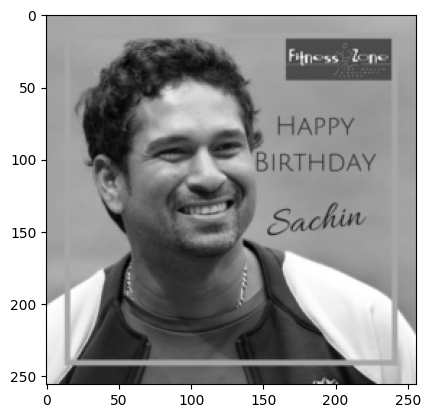

In [75]:
data_point = ds.train_dataset[898][0]
plt.imshow(data_point.permute(1,2,0),cmap='grey');


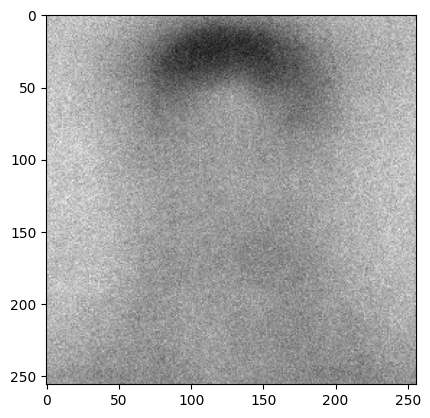

In [76]:
plt.imshow(model(data_point.view(1,1,256,256))[0].view(1,imgsz ,imgsz).permute(1,2,0).detach().numpy(),cmap="grey")